In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d msambare/fer2013
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

#### **Libraries**

In [ ]:
import os
import cv2
import imghdr
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

plt.style.use('default')
from keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential, Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras import layers, models, regularizers, optimizers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D

#### **Loading google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Set random seed**

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### **Defining the paths to your train and test directories**

In [ ]:
train_data_path = '/content/train/'
test_data_path = '/content/test/'

# List folders in the train and test directories
train_folders = os.listdir(train_data_path )
test_folders = os.listdir(test_data_path)

print("Folders in the train directory:")
print(train_folders)

print("\nFolders in the test directory:")
print(test_folders)

Folders in the train directory:
['neutral', 'sad', 'disgust', 'angry', 'happy', 'surprise', 'fear']

Folders in the test directory:
['neutral', 'sad', 'disgust', 'angry', 'happy', 'surprise', 'fear']


#### **Data Preprocessing and Augmentation for Emotion Detection**

In [ ]:
img_width, img_height = 224, 224
batch_size = 64
epochs = 10
num_classes = 7

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_path,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

valid_generator = data_generator.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),
    batch_size= batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_path,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### **Class Weights**

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)
train_generator.class_indices

Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-4]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

#### **Model definition**

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 33,298,951 (127.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

#### **Callbacks**

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path (you can adjust this to your desired location)
# Update the path to match the correct model checkpoint location in Google Drive
chk_path = '/content/drive/MyDrive/Emotion_Detection/VGG16_Model/VGG16_Output/VGG16_model_checkpoint.keras'


# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.50,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

#### **Train the model**

In [ ]:
# Train the model
history = model.fit(
    train_generator,  # your training dataset
    validation_data=test_generator,  # your validation dataset
    epochs=100,  # you can adjust the number of epochs as needed
    verbose=1,
    callbacks=[checkpoint, earlystop, reduce_lr]  # Add the callbacks
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.2714 - loss: 1.8184
Epoch 1: val_loss improved from inf to 1.36931, saving model to /content/model_checkpoint.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.2716 - loss: 1.8178 - val_accuracy: 0.4811 - val_loss: 1.3693 - learning_rate: 1.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.4605 - loss: 1.3967
Epoch 2: val_loss improved from 1.36931 to 1.25824, saving model to /content/model_checkpoint.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 380s 967ms/step - accuracy: 0.4605 - loss: 1.3966 - val_accuracy: 0.5291 - val_loss: 1.2582 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.5039 - loss: 1.3030
Epoch 3: val_loss improved from 1.25824 to 1.16633, saving model to /content/model_checkpoint.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 384s 969ms/step - accuracy: 0.5039 - loss: 1.3030 - val_accuracy: 0.5585 - val_loss: 1.1663 - learning_rate: 1.0000e-04
Epoch

#### **Plotting Training and Validation Accuracy and Loss Over Epochs**

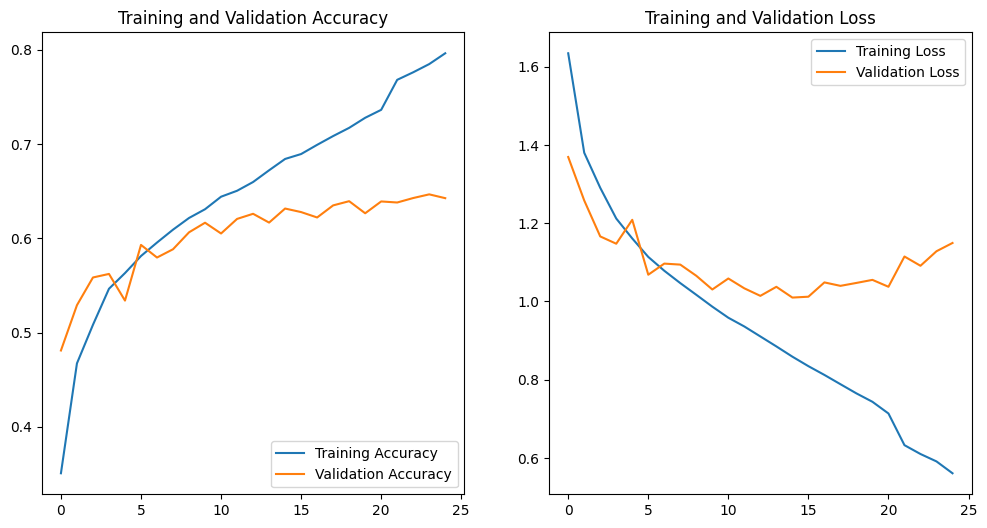

In [ ]:
# Plotting training and validation accuracy over epochs
def plot_accuracy_and_loss(history):
    # Extracting accuracy and loss values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Plotting accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot accuracy and loss
plot_accuracy_and_loss(history)


#### **Best Epoch and Accuracy**

In [ ]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1  # Adding 1 because index starts at 0
best_val_accuracy = max(history.history['val_accuracy'])

# Training accuracy at the best epoch
best_train_accuracy = history.history['accuracy'][best_epoch - 1]  # Subtract 1 because epochs are 1-indexed, and lists are 0-indexed

print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Training Accuracy at Best Epoch: {best_train_accuracy:.4f}")



Best Epoch: 24
Best Validation Accuracy: 0.6467
Training Accuracy at Best Epoch: 0.7849


#### **Loading the Best Model and Evaluating Performance on Test Data**

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved at the checkpoint
best_model = load_model(chk_path)

# Evaluate the model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

# Print test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")



113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 276ms/step - accuracy: 0.6288 - loss: 1.0171
Test Accuracy: 0.6317
Test Loss: 1.0100


#### **Comparison of Train, Validation, and Test Accuracy at Best Epoch**

In [ ]:
# Finding the best epoch based on validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Training and validation accuracy at the best epoch
best_train_accuracy = history.history['accuracy'][best_epoch - 1]
best_val_accuracy = history.history['val_accuracy'][best_epoch - 1]

# Evaluate on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"Best Epoch: {best_epoch}")
print(f"Training Accuracy at Best Epoch: {best_train_accuracy:.4f}")
print(f"Validation Accuracy at Best Epoch: {best_val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 285ms/step - accuracy: 0.6217 - loss: 1.0364
Best Epoch: 24
Training Accuracy at Best Epoch: 0.7849
Validation Accuracy at Best Epoch: 0.6467
Test Accuracy: 0.6317


#### **Confusion Matrix**

In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Step 1: Load the Best Model
best_model = load_model(chk_path)

# Step 2: Make Predictions on the Test Set
# Predict the labels for the test dataset
pred_probabilities = best_model.predict(test_generator)
pred_labels = np.argmax(pred_probabilities, axis=1)

# Step 3: Get the True Labels and Class Labels
true_labels = test_generator.classes  # True labels from the test generator
class_labels = list(test_generator.class_indices.keys())  # Class names

# Step 4: Create the Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Convert confusion matrix to string format for text annotations
cm_text = [[str(cell) for cell in row] for row in cm]

# Step 5: Plot the Confusion Matrix Using Plotly
fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=class_labels,  # Predicted labels
        y=class_labels,  # True labels
        colorscale='Blues',
        hoverongaps=False,
        text=cm_text,
        texttemplate="%{text}"
    ))

# Update layout for better readability
fig.update_layout(
    title="Confusion Matrix (VGG16 Model)",
    xaxis_title="Predicted Labels",
    yaxis_title="True Labels",
)

# Show the plot
fig.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 267ms/step


#### **Saving and Downloading the Trained CNN Model**

In [ ]:
model_dir = '/content/drive/MyDrive/Emotion_Detection/VGG16_Model/VGG16_Output/'
os.makedirs(model_dir, exist_ok=True)

# Save the trained VGG16 model to the created directory in Google Drive
best_model.save(model_dir + 'VGG16_model.keras')

# Download the saved model from Google Drive
from google.colab import files
files.download(model_dir + 'VGG16_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Saving the Accuracies**

In [ ]:
# Step 1: Identify the best epoch based on validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

# Step 2: Retrieve key metrics (accuracy and loss) with rounding
best_train_accuracy = round(history.history['accuracy'][best_epoch - 1], 2)
best_val_accuracy = round(history.history['val_accuracy'][best_epoch - 1], 2)
best_train_loss = round(history.history['loss'][best_epoch - 1], 2)
best_val_loss = round(history.history['val_loss'][best_epoch - 1], 2)

# Step 3: Load the best saved VGG16 model (adjust the path if needed)
VGG16_model_path = '/content/drive/MyDrive/Emotion_Detection/VGG16_Model/VGG16_Output/VGG16_model.keras'
VGG16_model = load_model(VGG16_model_path)

# Step 4: Evaluate the best model on test data
test_loss, test_accuracy = VGG16_model.evaluate(test_generator)
test_loss = round(test_loss, 2)
test_accuracy = round(test_accuracy, 2)

# Step 5: Collect all the metrics in a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['VGG16 Best Epoch', 'VGG16 Train Accuracy', 'VGG16 Validation Accuracy', 'VGG16 Train Loss', 'VGG16 Validation Loss', 'VGG16 Test Accuracy', 'VGG16 Test Loss'],
    'Value': [best_epoch, best_train_accuracy, best_val_accuracy, best_train_loss, best_val_loss, test_accuracy, test_loss]
})

# Step 6: Save the DataFrame and model to Google Drive or any local directory
save_path = '/content/drive/MyDrive/Emotion_Detection/VGG16_Model/VGG16_Output'
os.makedirs(save_path, exist_ok=True)

# Save the metrics as a CSV file
metrics_save_path = os.path.join(save_path, 'vgg16_model_metrics.csv')
metrics_df.to_csv(metrics_save_path, index=False)

# Save the best model
model_save_path = os.path.join(save_path, 'VGG16_model.keras')
VGG16_model.save(model_save_path)

print(f"Best model and metrics successfully saved to {save_path}")

# Display the DataFrame with metrics
metrics_df


113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 275ms/step - accuracy: 0.6395 - loss: 1.0116
Best model and metrics successfully saved to /content/drive/MyDrive/Emotion_Detection/VGG16_Model/VGG16_Output


,Metric,Value
0,VGG16 Best Epoch,15.00
1,VGG16 Train Accuracy,0.68
2,VGG16 Validation Accuracy,0.63
3,VGG16 Train Loss,0.86
4,VGG16 Validation Loss,1.01
5,VGG16 Test Accuracy,0.63
6,VGG16 Test Loss,1.01


#### **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


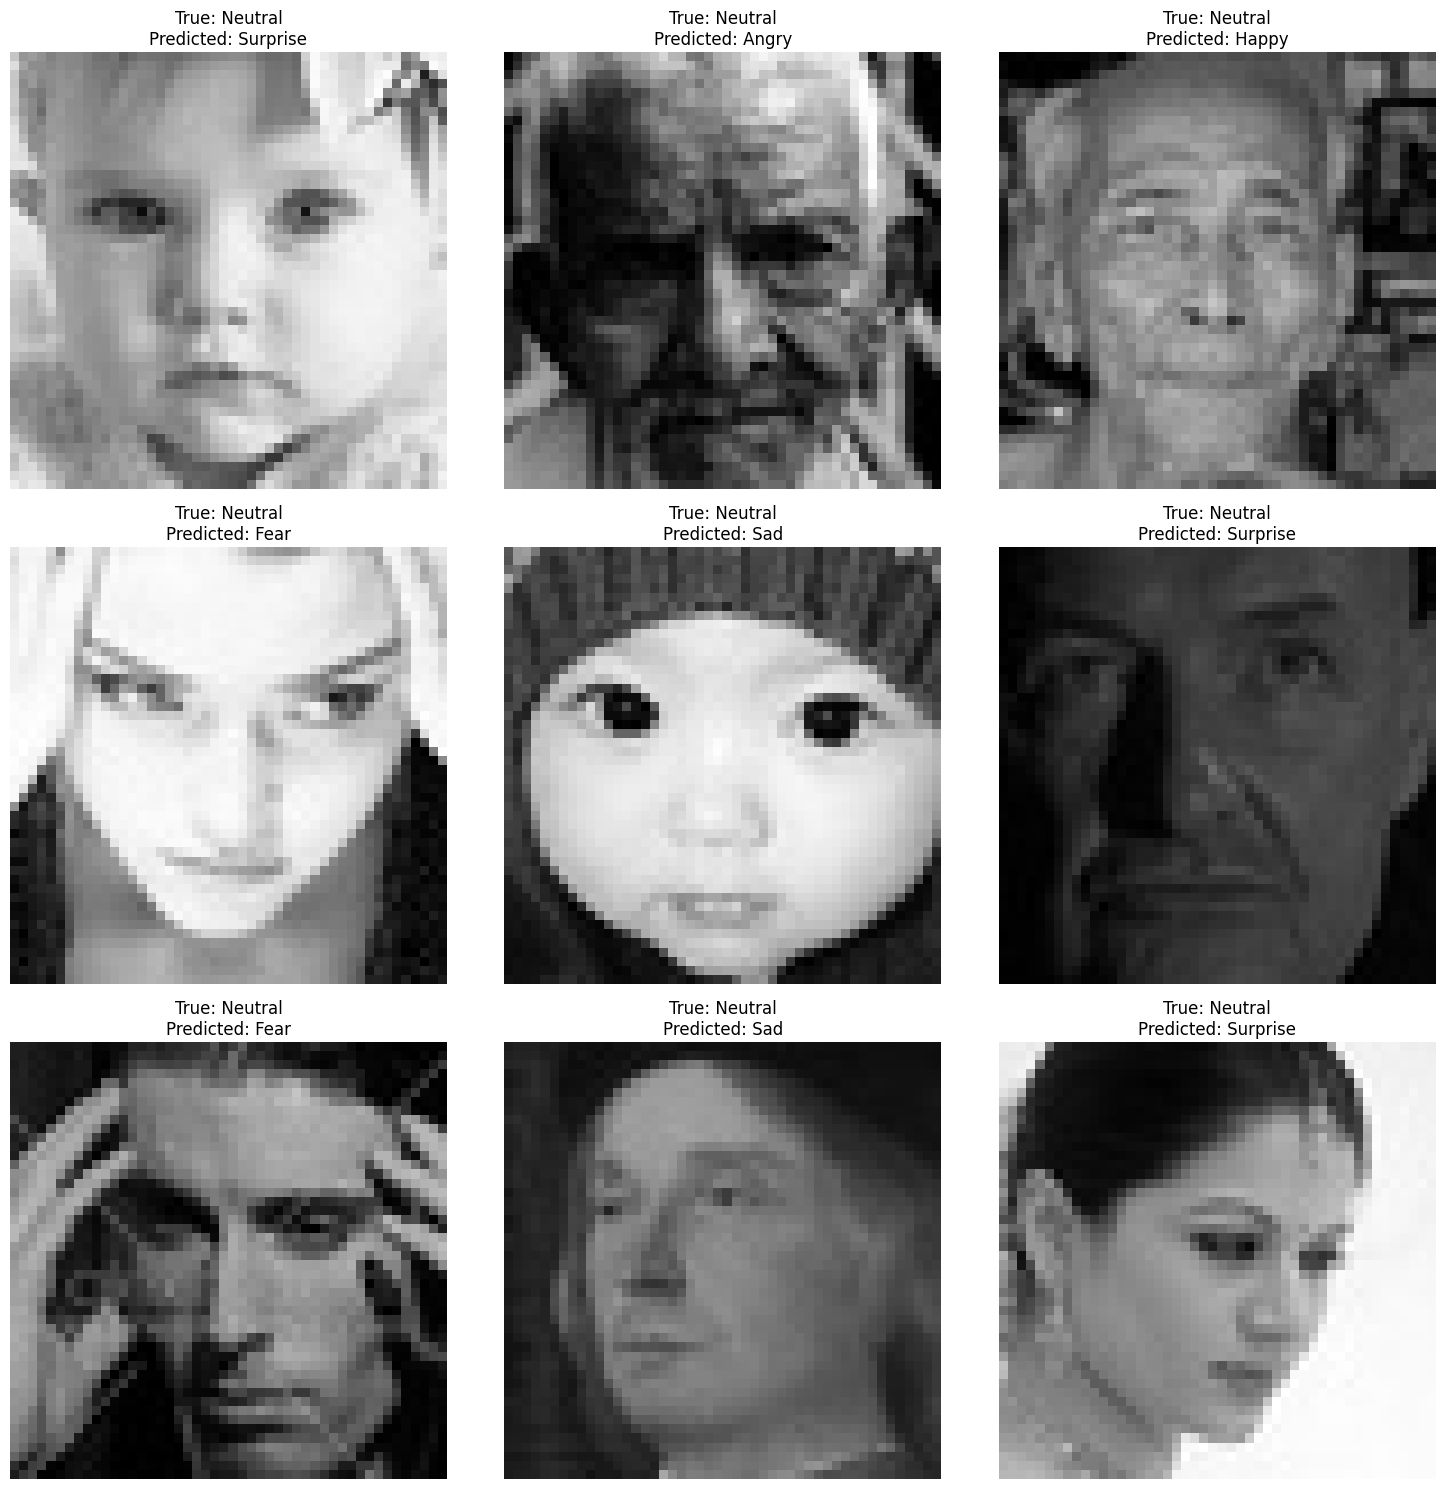

In [ ]:
# Load the trained VGG16 model
model_path = '/content/drive/MyDrive/Emotion_Detection/VGG16_Model/VGG16_Output/VGG16_model.keras'
VGG16_model = load_model(model_path)

# Function to load and preprocess an image for prediction using OpenCV
def load_and_preprocess_image_cv(img_path, target_size=(224, 224)):  # VGG16 expects 224x224 images
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img_array = np.expand_dims(img, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values to [0,1]
    return img_array

# Function to predict emotion for a single image using OpenCV
def predict_emotion_cv(img_path, model):
    img_array = load_and_preprocess_image_cv(img_path)
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction, axis=1)
    return predicted_label[0]

# Map of class indices to emotion labels
class_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Function to display images with predicted and true labels using OpenCV
def display_predictions_cv(images_dir, model, num_images=9):
    image_files = [os.path.join(root, file)
                   for root, _, files in os.walk(images_dir)
                   for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a subset of images to display
    selected_images = np.random.choice(image_files, num_images, replace=False)

    # Create a plot to display the images
    plt.figure(figsize=(15, 15))

    for i, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Since all images are from the 'neutral' class, set the true label as 'Neutral'
        true_label = 'Neutral'

        # Predict the emotion using the VGG16 model
        predicted_label = predict_emotion_cv(img_path, VGG16_model)
        predicted_label_name = class_labels[predicted_label]

        # Display the image with true and predicted labels
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label}\nPredicted: {predicted_label_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: Visualize predictions on the test images using OpenCV
test_images_dir = '/content/test/neutral'  # Path to test images
display_predictions_cv(test_images_dir, VGG16_model, num_images=9)
